# Denoising Diffusion Implicit Models (DDIMs)

## Definition

Denoising Diffusion Implicit Models (DDIMs) are a class of diffusion models that generate samples by iteratively denoising starting from noise, similar to DDPMs, but with a *non-Markovian* reverse process.

The forward process corrupts data:

$ q(x_t|x_{t-1}) = \mathcal{N}(\sqrt{\alpha_t}x_{t-1}, (1-\alpha_t)I)$

A closed-form expression exists:

$ x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1-\bar{\alpha}_t}\epsilon $

The reverse process in DDIM uses a deterministic update rule:

$$
x_{t-1} = \sqrt{\bar{\alpha}_{t-1}}\hat{x}_0(x_t,t) +
\sqrt{1 - \bar{\alpha}_{t-1} }\cdot \epsilon_{\theta}(x_t,t)
$$

Setting $\sigma_t = 0$ makes DDIM deterministic.

---

## Derivation Insight

From $x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1-\bar{\alpha}_t}\epsilon$

Rearranging gives a prediction for $x_0$:

$$ \hat{x}_0 = \frac{x_t - \sqrt{1-\bar{\alpha}_t}\epsilon_\theta}{\sqrt{\bar{\alpha}_t}} $$

Substituting into the reverse update yields DDIM sampling.

---

## Key Properties

- DDPM is a special case of DDIM  
- DDIM allows fewer denoising steps  
- Deterministic when $\sigma_t=0$  
- Enables image editing because noise mapping becomes invertible  


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

transform = transforms.Compose([
    transforms.ToTensor()
])

mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
loader = DataLoader(mnist_train, batch_size=64, shuffle=True)


Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 509kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.70MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.4MB/s]


## Minimal DDIM Noise Predictor

We train a neural network to approximate

$ \epsilon_{\theta}(x_t,t) $

This network receives noisy input $x_t$ and predicts the noise added to it.


In [2]:
class SimpleNoisePredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, 1, 1),
        )

    def forward(self, x, t):
        return self.conv(x)

model = SimpleNoisePredictor().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


## Forward Diffusion (Training Noise Generation)

We simulate:

$ x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1-\bar{\alpha}_t}\epsilon $


In [5]:
# Precompute alpha schedule
T = 200
beta = torch.linspace(0.0001, 0.02, T)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0).to(device)   # <-- FIX

def perturb(x0, t):
    noise = torch.randn_like(x0)

    # gather right elements per-sample
    sqrt_ab = torch.sqrt(alpha_bar[t]).view(-1,1,1,1)
    sqrt_1_ab = torch.sqrt(1-alpha_bar[t]).view(-1,1,1,1)

    return sqrt_ab*x0 + sqrt_1_ab*noise, noise

epochs = 10
for epoch in range(epochs):
    for i,(imgs,_) in enumerate(loader):
        imgs = imgs.to(device)

        t = torch.randint(0, T, (imgs.size(0),), device=device)  # GPU
        xt, eps = perturb(imgs, t)

        eps_pred = model(xt, t)
        loss = loss_fn(eps_pred, eps)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 200 == 0:
            print(f"Epoch {epoch}, Step {i}, Loss={loss.item():.4f}")


Epoch 0, Step 0, Loss=0.1182
Epoch 0, Step 200, Loss=0.0834
Epoch 0, Step 400, Loss=0.0848
Epoch 0, Step 600, Loss=0.0866
Epoch 0, Step 800, Loss=0.0771
Epoch 1, Step 0, Loss=0.0762
Epoch 1, Step 200, Loss=0.0859
Epoch 1, Step 400, Loss=0.0811
Epoch 1, Step 600, Loss=0.0894
Epoch 1, Step 800, Loss=0.0829
Epoch 2, Step 0, Loss=0.0652
Epoch 2, Step 200, Loss=0.0751
Epoch 2, Step 400, Loss=0.0762
Epoch 2, Step 600, Loss=0.0737
Epoch 2, Step 800, Loss=0.0762
Epoch 3, Step 0, Loss=0.0697
Epoch 3, Step 200, Loss=0.0764
Epoch 3, Step 400, Loss=0.0765
Epoch 3, Step 600, Loss=0.0613
Epoch 3, Step 800, Loss=0.0812
Epoch 4, Step 0, Loss=0.0779
Epoch 4, Step 200, Loss=0.0641
Epoch 4, Step 400, Loss=0.0623
Epoch 4, Step 600, Loss=0.0638
Epoch 4, Step 800, Loss=0.0611
Epoch 5, Step 0, Loss=0.0685
Epoch 5, Step 200, Loss=0.0774
Epoch 5, Step 400, Loss=0.0704
Epoch 5, Step 600, Loss=0.0751
Epoch 5, Step 800, Loss=0.0651
Epoch 6, Step 0, Loss=0.0661
Epoch 6, Step 200, Loss=0.0667
Epoch 6, Step 400, Los

## DDIM Sampling

We apply:

$$
x_{t-1} = \sqrt{\bar{\alpha}_{t-1}}\hat{x}_0 +
\sqrt{1-\bar{\alpha}_{t-1}}\cdot \epsilon_{\theta}(x_t,t)
$$

Deterministic because $\sigma_t=0$.


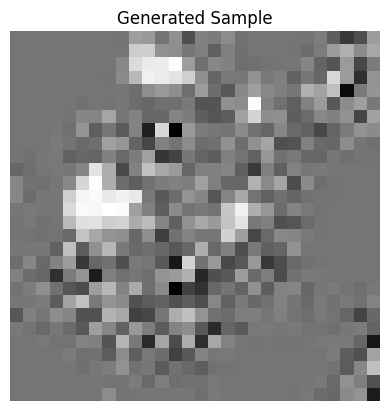

In [6]:
@torch.no_grad()
def ddim_sample():
    x = torch.randn(1,1,28,28, device=device)
    trajectory = []

    for t in reversed(range(1,T)):
        eps_theta = model(x, t)

        ab = alpha_bar[t]
        ab_prev = alpha_bar[t-1]

        x0_hat = (x - torch.sqrt(1-ab)*eps_theta)/torch.sqrt(ab)

        x = torch.sqrt(ab_prev)*x0_hat + torch.sqrt(1-ab_prev)*eps_theta

        trajectory.append(x.cpu().squeeze().numpy())

    return x.cpu().squeeze().numpy(), trajectory

sample, traj = ddim_sample()
plt.imshow(sample, cmap="gray")
plt.title("Generated Sample")
plt.axis("off")
plt.show()


## Noise Denoising Trajectory

We visualize a pixel over time to show how DDIM reduces noise deterministically.


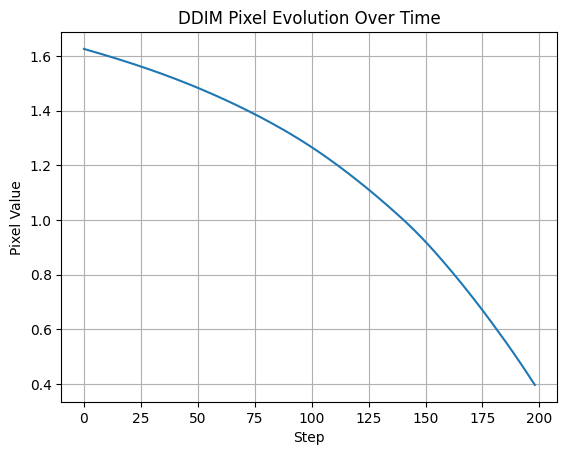

In [7]:
pixel_values = [t[14,14] for t in traj]  # center pixel evolution

plt.plot(pixel_values)
plt.title("DDIM Pixel Evolution Over Time")
plt.xlabel("Step")
plt.ylabel("Pixel Value")
plt.grid()
plt.show()


## 3D Latent Evolution

We treat (mean intensity, time, noise sum) as a trajectory.


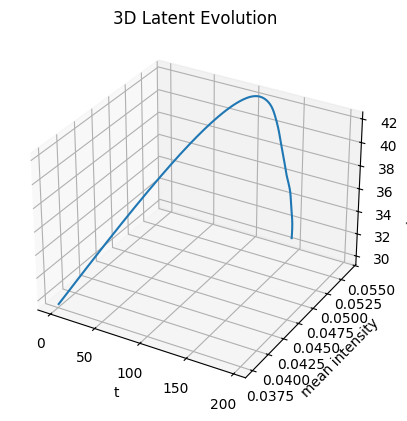

In [8]:
from mpl_toolkits.mplot3d import Axes3D

x = np.arange(len(traj))
y = [np.mean(t) for t in traj]
z = [np.sum(t) for t in traj]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x,y,z)
ax.set_title("3D Latent Evolution")
ax.set_xlabel("t")
ax.set_ylabel("mean intensity")
ax.set_zlabel("noise magnitude")
plt.show()


## Interpretation

- The 2D plot shows deterministic contraction of noise.
- The 3D curve illustrates structured evolution in latent space.

## Applications

- Faster sampling than DDPM
- Editable generation due to invertibility
- Used in Stable Diffusion
